# Kronecker-based Compressed Sensing signal recovery

In this notebook we explore the _compression_ and _recovery_ of aCompressive Sensing _compressible_ signal through __Compressive Sensing__ with __Kronecker Technique__

#### Utilities

In [121]:
def printFormatted(matrix, decimals=4):
    """
    Prints the matrix with formatted elements aligned in columns for improved readability.

    Requires:
    ----------
    numpy as np
    

    Parameters:
    ----------
    matrix : numpy array
        The matrix to be printed.
    decimals : int, optional (default=4)
        The number of decimal places for formatting the elements.

    Notes:
    -----
    - The function aligns columns based on the maximum width needed for the formatted elements, ensuring the matrix is displayed neatly.
    - This function is useful for visual inspection of numerical matrices, especially those with varying magnitudes.
    """
    # Determine the maximum width needed to keep alignment
    max_width = max(len(f'{value:.{decimals}f}') for row in matrix for value in row)

    # Create a formatted string for each element in the matrix, ensuring alignment
    formatted_matrix = '\n'.join([' '.join([f'{value:>{max_width}.{decimals}f}' for value in row]) for row in matrix])

    # Print the formatted matrix
    print(formatted_matrix)


In [122]:
# DEBUGGING PURPUSES
import os

# Directory where you want to save the CSV file
output_dir = 'debugCsvPy'  # global var that refers to the directory where the CSV file will be saved

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Measurement matrix

In [123]:
import numpy as np

def generate_DBDD_matrix(M, N):
    """
    Generates a deterministic Diagonally Blocked Block Diagonal (DBBD) matrix.

    Requires:
    ----------
    numpy as np


    Parameters:
    ----------
    M : int
        Number of rows in the matrix.
    N: int
        Number of columns in the matrix. Should be a multiple of M.

    Returns:
    -------
    A : numpy array
        The generated DBBD matrix of shape (M, N).
    """
    
    if N % M != 0:
        raise ValueError("N should be a multiple of M.")
    
    Phi = np.zeros((M, N))
    m = N // M
    
    for i in range(M):
        Phi[i, i*m:(i+1)*m] = 1

    return Phi


import numpy as np

def generate_random_matrix(M, N, matrix_type='gaussian'):
    """
    Generates a random matrix based on the specified type.

    Requires:
    ----------
    numpy as np
    

    Parameters:
    ----------
    M : int
        Number of rows in the matrix.
    N : int
        Number of columns in the matrix.
    matrix_type : str, optional (default='gaussian')
        The type of random matrix to generate. Options are:
        - 'gaussian': A matrix with entries drawn from a normal distribution.
        - 'scaled_binary': A matrix with binary entries (±0.5), scaled by 1/sqrt(M).
        - 'unscaled_binary': A matrix with binary entries (±1), with no scaling.

    Returns:
    -------
    A : numpy array
        The generated random matrix of shape (M, N).
    """
    
    if matrix_type == 'gaussian':
        A = ((1/M)**2) * np.random.randn(M, N)

    elif matrix_type == 'scaled_binary':
        A = np.random.binomial(1, 0.5, size=(M, N)) - 0.5
        A = (1/np.sqrt(M)) * A

    elif matrix_type == 'unscaled_binary':
        A = np.random.binomial(1, 0.5, size=(M, N)) * 2 - 1
        # This generates -1 or +1 directly without scaling

    else:
        raise ValueError("Unsupported matrix type. Choose either 'gaussian', 'scaled_binary', or 'unscaled_binary'.")

    return A



Test above code

In [124]:
N = 2 ** 4
M = N // 4

# Generate a deterministic DBBD matrix
A = generate_DBDD_matrix(M, N)
print(f'DBBD:\n{A}\n\n')

# Generate a random Gaussian matrix
B = generate_random_matrix(M, N, matrix_type='gaussian')
print(f'gaussian:\n{B}\n\n')

# Generate a random scaled binary matrix
C = generate_random_matrix(M, N, matrix_type='scaled_binary')
print(f'scaled binary:\n{C}\n\n')

# Generate a random unscaled binary matrix
D = generate_random_matrix(M, N, matrix_type='unscaled_binary')
print(f'unscaled binary:\n{D}\n\n')


DBBD:
[[1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]]


gaussian:
[[-0.01031304 -0.07283876 -0.04261368 -0.14745482 -0.10039201 -0.0109652
  -0.06598249 -0.03048871  0.06268452  0.03488878 -0.07995025 -0.07425358
  -0.04048057 -0.07463625 -0.02914294 -0.03152876]
 [ 0.01335803  0.05532764  0.07961259 -0.00499276 -0.14495274  0.01202759
   0.12412284  0.02431654  0.06830645 -0.07925025  0.06417884  0.04104477
   0.11591756 -0.01515491 -0.02715755  0.1069138 ]
 [-0.08227507  0.14880023 -0.03439671  0.0967536  -0.0982125  -0.08703409
  -0.03147723 -0.01279521  0.05304141 -0.00232676  0.06470817 -0.04654015
   0.02759487 -0.1026004   0.04721123 -0.00819799]
 [-0.02566818 -0.08120985  0.10451892  0.06010034 -0.04891707  0.00626776
   0.05118463  0.08294656  0.04702586  0.04812721  0.0092854  -0.04745842
   0.08106161 -0.04223853  0.1153

#### Generate dictionary

DCT

In [125]:
import numpy as np
import scipy.fftpack as fftpack

def generate_dct_dictionary(N):
    """
    Generates a Discrete Cosine Transform (DCT) basis dictionary.

    Requires:
    ----------
    numpy as np
    scipy.fftpack as fftpack

    
    Parameters:
    ----------
    N : int
        The size of the dictionary (i.e., the length of the signal).

    Returns:
    -------
    dict_matrix : numpy array
        The generated DCT dictionary matrix of shape (N, N).
    """
    
    # Generate a DCT basis dictionary
    dict_matrix = fftpack.dct(np.eye(N), norm='ortho')
    
    return dict_matrix


Test above code

In [126]:
# compute reduction of matrix to independent columns
def compute_independent_columns(A, tol=1e-10):
    """
    Computes the independent columns of a matrix using the QR decomposition.

    Requires:
    ----------
    numpy as np


    Parameters:
    ----------
    A : numpy array
        The matrix for which to compute the independent columns.
    tol : float, optional (default=1e-10)
        The tolerance value for considering singular values as zero.

    Returns:
    -------
    ind_cols : numpy array
        The matrix containing the independent columns of A.

    Notes:
    -----
    - The function uses the QR decomposition to identify and select the independent columns of the matrix `A`.
    - The rank of the matrix is determined by checking the diagonal elements of the `R` matrix from the QR decomposition.
    - Columns corresponding to non-zero diagonal elements of `R` are considered independent.
    """
    # Perform the QR decomposition
    Q, R = np.linalg.qr(A)

    # Find the independent columns based on the rank of R
    rank = np.sum(np.abs(np.diagonal(R)) > tol)
    ind_cols = A[:, :rank]

    return ind_cols


def check_normalization(A):
    """
    Checks if the columns of a matrix are normalized (i.e., each column has a unit norm).

    Requires:
    ----------
    numpy as np

    Parameters:
    ----------
    A : numpy array
        The matrix to check for normalization.

    Returns:
    -------
    is_normalized : bool
        True if the columns of A are normalized, False otherwise.

    Notes:
    -----
    - The function calculates the norm of each column in the matrix `A`.
    - It then checks if all column norms are close to 1.0, which indicates normalization.
    """
    column_norms = np.linalg.norm(A, axis=0)
    is_normalized = np.allclose(column_norms, 1.0)
    return is_normalized


def compute_coherence(matrix):
    """
    Computes the coherence of the given matrix.
    
    Parameters:
    matrix (numpy.ndarray): An N x M matrix where coherence is to be calculated.
    
    Returns:
    float: The coherence of the matrix.
    """
    # Normalize the columns of the matrix
    normalized_matrix = matrix / np.linalg.norm(matrix, axis=0, keepdims=True)
    
    # Compute the Gram matrix (inner products between all pairs of columns)
    gram_matrix = np.dot(normalized_matrix.T, normalized_matrix)
    
    # Remove the diagonal elements (which are all 1's) to only consider distinct columns
    np.fill_diagonal(gram_matrix, 0)
    
    # Compute the coherence as the maximum absolute value of the off-diagonal elements
    coherence = np.max(np.abs(gram_matrix))
    
    return coherence



In [127]:
DIM = 16

# Generate dictionary
A = generate_dct_dictionary(DIM)
print(f'Dictionary shape: {A.shape}')
#printFormatted(Dict, decimals=4)
print()

# Orthonormality test
print("Orthonormality test")

# Check orthogonality
rankA = np.linalg.matrix_rank(A)
#print(f'Rank of A: {rankA}')
if A.shape[0] == rankA or A.shape[1] == rankA:
    print("Matrix A is full rank.")
#print(f'Original shape: {A.shape}')
#A = compute_independent_columns(A)
#A = compute_independent_columns(A.T)
#print(f'Full rank shape: {A.shape}')
#printFormatted(A, decimals=4)

# Check normalization
#print()
is_normalized = check_normalization(A)
print(f"Matrix A is normalized: {is_normalized}")
is_normalized = check_normalization(A.T)
print(f"Matrix A^T is normalized: {is_normalized}")
print()


# Coherence test
print("Coherence test")
coherence = compute_coherence(A)
print(f'Coherence: {coherence}')



Dictionary shape: (16, 16)

Orthonormality test
Matrix A is full rank.
Matrix A is normalized: True
Matrix A^T is normalized: True

Coherence test
Coherence: 1.670992254306886e-16


#### Sampling Phase

In [128]:
def compressSignal(signal,Phi):
    """
    """
    
    # length of signal block
    N = Phi.shape[1]

    # length of compressed block
    M = Phi.shape[0]

    # number of blocks
    BLOCK_NUM = len(signal) // N

    # each column of Y is the compressed version of a block of signal
    Y = np.zeros((M, BLOCK_NUM))    
    for i in range(BLOCK_NUM):
        Y[:,i] = Phi @ signal[i*N:(i+1)*N]
    
    return Y

#### Reconstruction method: Smooth-L0 (SL0)

In [129]:
import numpy as np

def SL0(y, A, sigma_min, sigma_decrease_factor=0.5, mu_0=2, L=3, A_pinv=None, showProgress=False):
    """
    Returns the sparsest vector `s` that satisfies the underdetermined system of 
    linear equations `A @ s = y`, using the Smoothed L0 (SL0) algorithm.

    Requires:
    --------
    - numpy as np
    

    Parameters:
    ----------
    y : numpy array
        The observed vector (Mx1), where M is the number of rows in `A`.
    
    A : numpy array
        The measurement matrix (MxN), which should be 'wide', meaning it has more 
        columns than rows (N > M). The number of rows in `A` must match the length 
        of `y`.
    
    sigma_min : float
        The minimum value of `sigma`, which determines the stopping criterion for 
        the algorithm. It should be chosen based on the noise level or desired 
        accuracy.
    
    sigma_decrease_factor : float, optional (default=0.5)
        The factor by which `sigma` is decreased in each iteration. This should be 
        a positive value less than 1. Smaller values lead to quicker reduction of 
        `sigma`, possibly at the cost of accuracy for less sparse signals.
    
    mu_0 : float, optional (default=2)
        The scaling factor for `mu`, where `mu = mu_0 * sigma^2`. This parameter 
        influences the convergence rate of the algorithm.
    
    L : int, optional (default=3)
        The number of iterations for the inner loop (steepest descent). Increasing 
        `L` can improve the precision of the result but also increases computational 
        cost.
    
    A_pinv : numpy array, optional
        The precomputed pseudoinverse of the matrix `A`. If not provided, it will be 
        calculated within the function as `np.linalg.pinv(A)`. Providing this value 
        is beneficial if the function is called repeatedly with the same `A`.
    
    showProgress : bool, optional (default=False)
        If `True`, the function prints the current value of `sigma` during each 
        iteration, which helps monitor the convergence process.

    Returns:
    -------
    s : numpy array
        The estimated sparse signal (Nx1) that best satisfies the equation `A @ s = y`.

    Notes:
    -----
    - The algorithm works by iteratively reducing `sigma` in a geometric sequence, 
      starting with `sigma = 2 * max(abs(s))` and ending with `sigma_min`. At each 
      step, the function adjusts `s` to minimize the L0-norm by smoothing it using 
      a Gaussian kernel.
    
    - The choice of `sigma_min` is crucial: for noiseless cases, a smaller `sigma_min` 
      yields a sparser solution; for noisy cases, `sigma_min` should be a few times 
      the standard deviation of the noise in `s`.

    - If `A_pinv` is precomputed and passed as an argument, the function becomes 
      more efficient, especially in scenarios where it is called repeatedly with the 
      same `A`.

    """

    if A_pinv is None:
        A_pinv = np.linalg.pinv(A)

    # Initialize the variables
    s = A_pinv @ y
    sigma = 2 * max(np.abs(s))

    # Define lambda function for delta
    OurDelta = lambda s, sigma: s * np.exp(-s**2 / sigma**2)
 
    # Main loop
    while sigma > sigma_min:
        for i in range(L):
            delta = OurDelta(s, sigma)
            s = s - mu_0 * delta
            s = s - A_pinv @ (A @ s - y)
        
        if showProgress:
            print(f'sigma: {sigma}')

        sigma = sigma * sigma_decrease_factor

    return s


#### Recovery

Non-kronecker

In [130]:
def non_kron_recovery(Y, sigma_min, Phi, sigma_decrease_factor=0.5, mu_0=2, L=3, showProgress=False):


    
    n_block = Phi.shape[1]  # length of ORIGINAL signal block
    Dict = generate_dct_dictionary(n_block)  # Dictionary
    Theta = Phi @ Dict  # Theta
    Theta_pinv = np.linalg.pinv(Theta)  # More-Penrose pseudoinverse of Theta
    BLOCK_NUM = Y.shape[1]  # number of blocks

    n_block = Theta.shape[1]  # length of ORIGINAL signal block

    # Prepare output files
    output_dir = 'debugCsvPy'  # Directory where CSV files will be stored
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Define file paths
    y_block_path = os.path.join(output_dir, 'y_block.csv')
    s_block_path = os.path.join(output_dir, 's_block.csv')

    # Delete files if they exist
    if os.path.exists(y_block_path):
        os.remove(y_block_path)
    if os.path.exists(s_block_path):
        os.remove(s_block_path)

    # Initialize the recovered signal
    x_hat = np.zeros(BLOCK_NUM * n_block)  # Recovered signal will be as long as the original signal

    # Process each block
    for i in range(BLOCK_NUM):
        y = Y[:, i]
        s_block = SL0(y, Theta, sigma_min, sigma_decrease_factor, mu_0, L, Theta_pinv, showProgress)
        x_hat[i*n_block:(i+1)*n_block] = Dict @ s_block

        # Append y to y_block.csv
        with open(y_block_path, 'a') as f_y:
            np.savetxt(f_y, y.reshape(1, -1), delimiter=',', fmt='%.6f')

        # Append s_block to s_block.csv
        with open(s_block_path, 'a') as f_s:
            np.savetxt(f_s, s_block.reshape(1, -1), delimiter=',', fmt='%.6f')
        

    # DEBUGGING
    np.savetxt(f'{output_dir}/A1_Theta.csv', Theta, delimiter=',', fmt='%.6f')
    np.savetxt(f'{output_dir}/dict1_Dict.csv', Dict, delimiter=',', fmt='%.6f')
    np.savetxt(f'{output_dir}/A_pinv1.csv', Theta_pinv, delimiter=',', fmt='%.6f')


    return x_hat


Kronecker-based

In [131]:
import os
import numpy as np


def kron_recovery(Y, sigma_min, Phi, kron_factor, sigma_decrease_factor=0.5, mu_0=2, L=3, showProgress=False):



    Phi_kron = np.kron(np.eye(kron_factor), Phi)  # KRONECKER product of Phi (kroncker measurement matrix)

    n_block = Phi.shape[1]  # length of ORIGINAL signal block
    #m_block = Phi.shape[0]  # length of compressed signal block
    n_block_kron = Phi_kron.shape[1]  # length of ORIGINAL signal KRONECKER-block
    #m_block_kron = Phi_kron.shape[0]  # length of compressed signal KRONECKER-block

    BLOCK_NUM = Y.shape[1]  # number of blocks
    N = n_block * BLOCK_NUM  # length of ORIGINAL signal
    KRON_BLOCK_NUM = N // n_block_kron  # number of KRONECKER blocks

    Dict_kron = generate_dct_dictionary(n_block_kron)  # Dictionary (kron)
    Theta_kron = Phi_kron @ Dict_kron  # Theta (kron)
    Theta_kron_pinv = np.linalg.pinv(Theta_kron)  # More-Penrose pseudoinverse of Theta (kron)


    
    # Prepare output files
    output_dir = 'debugCsvPy'  # Directory where CSV files will be stored
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Define file paths
    y_concatenated_path = os.path.join(output_dir, 'y_concatenated.csv')
    s_block_kron_path = os.path.join(output_dir, 's_block_kron.csv')

    # Delete files if they exist
    if os.path.exists(y_concatenated_path):
        os.remove(y_concatenated_path)
    if os.path.exists(s_block_kron_path):
        os.remove(s_block_kron_path)

    # Initialize the recovered signal
    x_hat_kron = np.zeros(N)

    # Process each block
    for i in range(KRON_BLOCK_NUM):
        y_kron = Y[:, i*kron_factor:(i+1)*kron_factor].flatten()

        # Print y_kron shape (for debugging)
        print(f'y_kron shape: {y_kron.shape}')
        print(y_kron)
        print('---')

        s_kron_block = SL0(y_kron, Theta_kron, sigma_min, sigma_decrease_factor, mu_0, L, Theta_kron_pinv, showProgress)
        x_hat_kron[n_block_kron*i:(i+1)*n_block_kron] = Dict_kron @ s_kron_block

        # Append y_kron to y_concatenated.csv
        with open(y_concatenated_path, 'a') as f_y_kron:
            np.savetxt(f_y_kron, y_kron.reshape(1, -1), delimiter=',', fmt='%.6f')
            # Write a line of zeros to separate blocks
            np.savetxt(f_y_kron, np.zeros_like(y_kron.reshape(1, -1)), delimiter=',', fmt='%.6f')

        # Append s_kron_block to s_block_kron.csv
        with open(s_block_kron_path, 'a') as f_s_kron:
            np.savetxt(f_s_kron, s_kron_block.reshape(1, -1), delimiter=',', fmt='%.6f')
            # Write a line of zeros to separate blocks
            np.savetxt(f_s_kron, np.zeros_like(s_kron_block.reshape(1, -1)), delimiter=',', fmt='%.6f')

    # DEBUGGING
    np.savetxt(f'{output_dir}/AA_Phi_kron.csv', Phi_kron, delimiter=',', fmt='%.6f')
    np.savetxt(f'{output_dir}/A2_Theta.csv', Theta_kron, delimiter=',', fmt='%.6f')
    np.savetxt(f'{output_dir}/dict2_Dict_kron.csv', Dict_kron, delimiter=',', fmt='%.6f')
    np.savetxt(f'{output_dir}/A_pinv2.csv', Theta_kron_pinv, delimiter=',', fmt='%.6f')
    


    return x_hat_kron




#### Evaluation of results

SNR

In [132]:
import numpy as np

def calculate_snr(signal, recovered_signal):
    """
    Calculates the Signal-to-Noise Ratio (SNR) between the original signal and the recovered signal.

    Parameters:
    ----------
    signal : numpy array
        The original signal.
    recovered_signal : numpy array
        The recovered signal after some processing or recovery algorithm.

    Returns:
    -------
    snr : float
        The Signal-to-Noise Ratio (SNR) in decibels (dB).

    Notes:
    -----
    - The SNR is calculated as 20 * log10(norm(original_signal) / norm(original_signal - recovered_signal)).
    - A higher SNR value indicates a better recovery, with less error relative to the original signal.
    """
    error = recovered_signal - signal
    snr = 20 * np.log10(np.linalg.norm(signal) / np.linalg.norm(error))
    
    return snr


Plot recovered over original

In [133]:
import matplotlib.pyplot as plt
import numpy as np

def plot_signals(original_signal, reconstructed_signal, original_name="Original Signal", reconstructed_name="Reconstructed Signal"):
    """
    Plots the original signal and the reconstructed signal on the same plot with the given names.

    Requires:
    ----------
    - matplotlib.pyplot as plt
    - numpy as np

    Parameters:
    ----------
    original_signal : numpy array
        The original signal to be plotted.
    
    reconstructed_signal : numpy array
        The reconstructed signal to be plotted.
    
    original_name : str, optional (default="Original Signal")
        The name to display for the original signal in the plot.
    
    reconstructed_name : str, optional (default="Reconstructed Signal")
        The name to display for the reconstructed signal in the plot.
    """
    
    # Ensure the signals have the same length
    if len(original_signal) != len(reconstructed_signal):
        raise ValueError("The original signal and the reconstructed signal must have the same length.")
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(original_signal, label=original_name, color='blue', linewidth=1.5)
    plt.plot(reconstructed_signal, label=reconstructed_name, color='red', linestyle='--', linewidth=1.5)
    plt.title(f"{original_name} vs {reconstructed_name}")
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()



#### Code execution

Signal shape: (2048,)


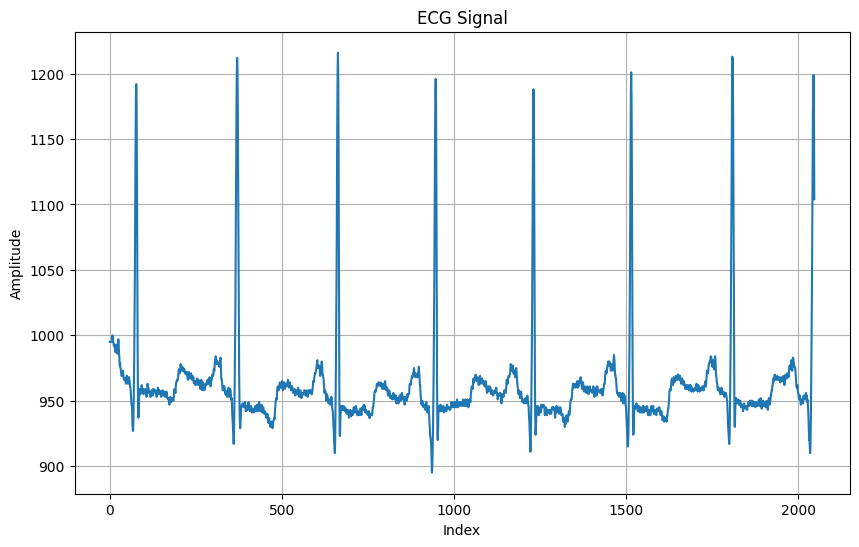

y_kron shape: (128,)
[3980. 3958. 3884. 3873. 3750. 3937. 3827. 3831. 3830. 3827. 3815. 3803.
 3855. 3897. 3875. 3872. 3858. 3843. 3862. 3915. 3920. 3821. 3805. 4784.
 3789. 3784. 3768. 3786. 3763. 3732. 3788. 3844. 3980. 3951. 3884. 3860.
 3804. 3806. 3832. 3817. 3824. 3820. 3818. 3806. 3867. 3895. 3879. 3856.
 3848. 3845. 3852. 3926. 3860. 3823. 3725. 4356. 3787. 3777. 3779. 3777.
 3757. 3732. 3818. 3846. 3986. 3969. 3867. 3859. 4305. 3829. 3824. 3830.
 3820. 3823. 3807. 3812. 3892. 3891. 3873. 3851. 3854. 3852. 3873. 3917.
 3836. 3826. 3745. 3779. 3783. 3779. 3777. 3777. 3754. 3725. 3837. 3853.
 3966. 3914. 3861. 3816. 4677. 3840. 3839. 3828. 3830. 3826. 3799. 3831.
 3901. 3884. 3874. 3865. 3842. 3857. 3887. 3908. 3836. 3831. 4206. 3764.
 3777. 3770. 3779. 3773. 3738. 3744. 3850. 3844.]
---
y_kron shape: (128,)
[3846. 3841. 3825. 3821. 3824. 3865. 3895. 3828. 3792. 3971. 3782. 3767.
 3763. 3763. 3778. 3758. 3823. 3847. 3844. 3813. 3800. 3815. 3815. 3881.
 3892. 3786. 3723. 4631. 378

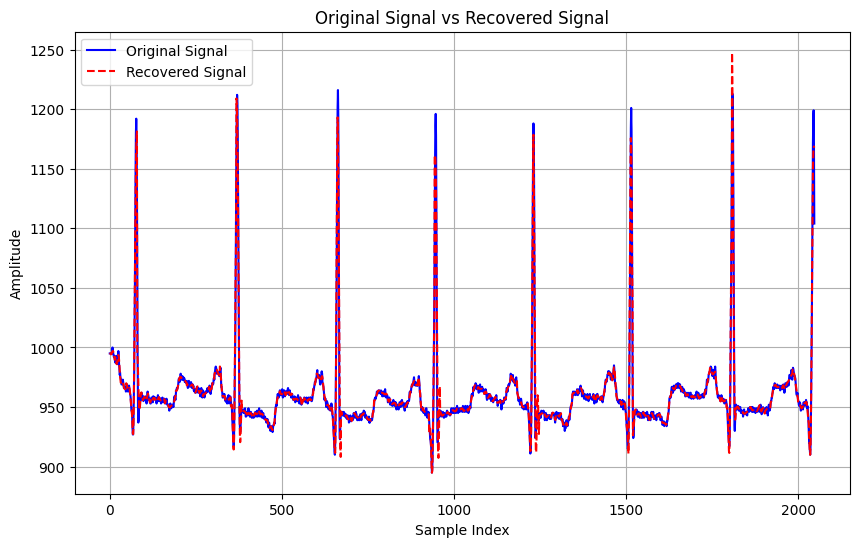

SNR: 43.322906872298894 dB


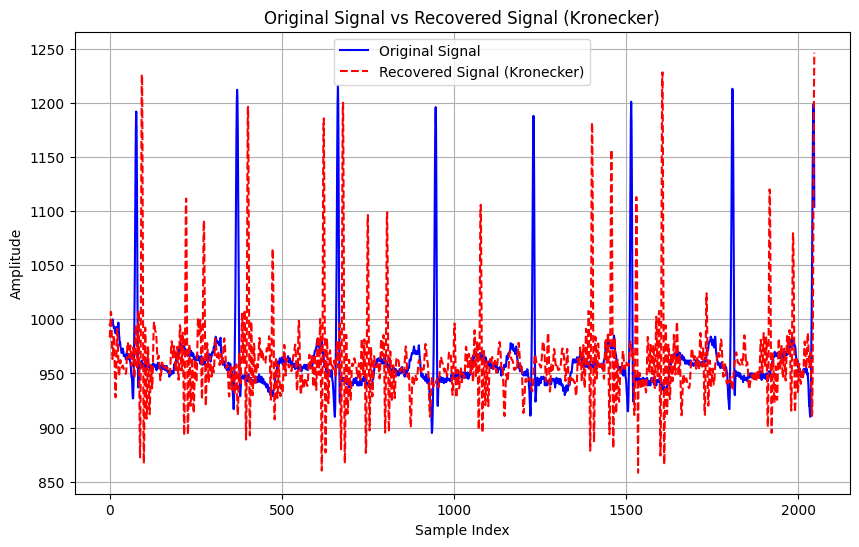

SNR (Kronecker): 25.472189217235904 dB


In [134]:
import scipy.io
import matplotlib.pyplot as plt

if __name__ == "__main__":


    ### PREPARE
    # ----------------------------------------------------------------

    ## DATA
    #  upload data
    data = scipy.io.loadmat('100m.mat')
    # retrieve the key to a string
    key = list(data.keys())[0]
    # retrieve the values
    signal = data[key][0,:]  # [0 or 1, 0:650000] s.t. first dim: (0 is MLII, 1 is V5)
    # pick only 2048 samples, because it will be Kronecker block dimension
    start = int(512 * 0)
    end = int(start + 512*4)
    signal = signal[start:end]
    # print the shape of the signal
    print(f'Signal shape: {signal.shape}') 
    # plot the signal
    plt.figure(figsize=(10, 6))
    plt.plot(signal)
    plt.title('ECG Signal')
    plt.xlabel('Index')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()    

    # DEBUGGING
    # save the matrix to a CSV file
    np.savetxt(os.path.join(output_dir, 'signal.csv'), signal, delimiter=',', fmt='%.6f')


    ## PARAMETERS
    # compression ratio
    CR = 1/4 
    # non-kronecker
    n_block = 16 # block size`
    m_block = int(n_block * CR) # compressed block size
    # kronecker
    n_block_kron = 512 # kron block size
    m_block_kron = int(n_block_kron * CR) # compressed kron block size
    kron_factor = n_block_kron // n_block # kron factor



    ### SAMPLING PHASE 
    # ----------------------------------------------------------------


    ## MEASUREMENT MATRIX
    # generate the measurement matrix
    Phi = generate_DBDD_matrix(m_block, n_block)
    #Phi = generate_random_matrix(m_block, n_block, matrix_type='gaussian')
    #Phi = generate_random_matrix(m_block, n_block, matrix_type='scaled_binary')
    #Phi = generate_random_matrix(m_block, n_block, matrix_type='unscaled_binary')


    # DEBUGGING
    # save the matrix to a CSV file
    np.savetxt(os.path.join(output_dir, 'A_Phi.csv'), Phi, delimiter=',', fmt='%.6f')


    ## COMPRESS THE SIGNAL
    # compress the signal
    Y = compressSignal(signal, Phi)

    # DEBUGGING
    # save the matrix to a CSV file
    np.savetxt(os.path.join(output_dir, 'Y.csv'), Y, delimiter=',', fmt='%.6f')



    ### RECOVERY PHASE
    # ----------------------------------------------------------------


    ## SL0 PARAMETERS
    sigma_off = 0.001  # offset for sigma
    mu_0 = 2  # scaling factor for mu
    sigma_decrease_factor = 0.5  # factor for decreasing sigma
    L = 3  # number of iterations for the inner loop
    if sigma_off > 0:
        sigma_min = sigma_off * 4  # minimum value of sigma
    else:
        sigma_min = 0.00001  # minimum value of sigma



    ## RECOVERY non-KRONECKER
    # recover the signal
    recovered_signal = non_kron_recovery(Y=Y, sigma_min=sigma_min, Phi=Phi, sigma_decrease_factor=sigma_decrease_factor,
                                            mu_0=mu_0, L=L, showProgress=False)
    

    ## RECOVERY KRONECKER
    # recover the signal

    recovered_signal_kron = kron_recovery(Y=Y, sigma_min=sigma_min, Phi=Phi, sigma_decrease_factor=sigma_decrease_factor,
                                            mu_0=mu_0, L=L, showProgress=False, kron_factor=kron_factor)
    




    ### EVALUATION
    # ----------------------------------------------------------------


    ## PLOT
    # plot the signals
    plot_signals(signal, recovered_signal, original_name="Original Signal", reconstructed_name="Recovered Signal")

    ## SNR
    # calculate the SNR
    snr = calculate_snr(signal, recovered_signal)
    print(f'SNR: {snr} dB')

    ## PLOT KRON
    # plot the signals
    plot_signals(signal, recovered_signal_kron, original_name="Original Signal", reconstructed_name="Recovered Signal (Kronecker)")
    

    ## SNR KRON
    # calculate the SNR
    snr_kron = calculate_snr(signal, recovered_signal_kron)
    print(f'SNR (Kronecker): {snr_kron} dB')



Check if variables are the same as the ones in MATLAB

In [135]:
import os
import pandas as pd
import numpy as np

def compare_csv_matrices(dir1, dir2):
    # List CSV files in both directories
    files_dir1 = set(f for f in os.listdir(dir1) if f.endswith('.csv'))
    files_dir2 = set(f for f in os.listdir(dir2) if f.endswith('.csv'))
    
    # Find common files
    common_files = files_dir1.intersection(files_dir2)
    
    # Report if any files are missing in either directory
    missing_in_dir1 = files_dir2 - files_dir1
    missing_in_dir2 = files_dir1 - files_dir2
    
    if missing_in_dir1:
        print(f"Files missing in {dir1}: {', '.join(missing_in_dir1)}")
    if missing_in_dir2:
        print(f"Files missing in {dir2}: {', '.join(missing_in_dir2)}")
    
    # Compare contents of common files
    mismatches = []
    for filename in common_files:
        path1 = os.path.join(dir1, filename)
        path2 = os.path.join(dir2, filename)
        
        # Read CSV files
        df1 = pd.read_csv(path1, header=None)
        df2 = pd.read_csv(path2, header=None)
        
        # Compare as numpy arrays
        if not np.array_equal(df1.values, df2.values):
            mismatches.append(filename)
    
    # Report results
    if mismatches:
        print("Files with mismatched content:")
        for filename in mismatches:
            print(f"- {filename}")
    else:
        print("All files match!")

# Example usage
compare_csv_matrices('../debugMatlab/debugCsvMAT', './debugCsvPy')


Files missing in ../debugMatlab/debugCsvMAT: A2_Theta.csv
Files missing in ./debugCsvPy: A2_Theta_kron.csv
Files with mismatched content:
- s_block_kron.csv
- y_concatenated.csv
